In [51]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()

import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# DATASET

## Vocal Sound

In [53]:
### Features for Vocal Sound

# Data with GEMAPS features:
vocalsound_gemaps_file = pd.read_csv('vocalsound_gemaps_common.csv')
vocalsound_gemaps_dataset = vocalsound_gemaps_file.to_numpy()

# Data with eGEMAPS features:
vocalsound_egemaps_file = pd.read_csv('vocalsound_egemaps_common.csv')
vocalsound_egemaps_dataset = vocalsound_egemaps_file.to_numpy()

# Data with Interspeech 2009 features:
vocalsound_is09_file = pd.read_csv('vocalsound_IS09_common.csv')
vocalsound_is09_dataset = vocalsound_is09_file.to_numpy()

# Data with Interspeech 2010 features:
vocalsound_is10_file = pd.read_csv('vocalsound_IS10_common.csv')
vocalsound_is10_dataset = vocalsound_is10_file.to_numpy()

# Data with Interspeech 2013 features:
vocalsound_is13_file = pd.read_csv('vocalsound_IS13_common.csv')
vocalsound_is13_dataset = vocalsound_is13_file.to_numpy()

# target values:
vocalsound_targets_gemaps = np.loadtxt('target_values_gemaps_vocalsound.csv')
vocalsound_targets_egemaps = np.loadtxt('target_values_egemaps_vocalsound.csv')
vocalsound_targets_is09 = np.loadtxt('target_values_IS09_vocalsound.csv')
vocalsound_targets_is10 = np.loadtxt('target_values_IS10_vocalsound.csv')
vocalsound_targets_is13 = np.loadtxt('target_values_IS13_vocalsound.csv')

## Classes in the Vocal Sound dataset

In [54]:
### Classes in the Vocal Sound dataset
VS_classes = {'0': 'cough/кашель              ',
              '1': 'laugh/смех                ',
              '2': 'sigh/вздох                ',
              '3': 'sneeze/чихание            ',
              '4': 'sniff/вдыхание носом      ',
              '5': 'throatcl./прочищение горла'}

### Vocal Sound Scores
scores_VS = {'recall0': make_scorer(recall_score, average = None, labels = [0]), 
            'recall1': make_scorer(recall_score, average = None, labels = [1]),
            'recall2': make_scorer(recall_score, average = None, labels = [2]),
            'recall3': make_scorer(recall_score, average = None, labels = [3]),
            'recall4': make_scorer(recall_score, average = None, labels = [4]),
            'recall5': make_scorer(recall_score, average = None, labels = [5]),
       
            'precision0': make_scorer(precision_score, average = None, labels = [0]), 
            'precision1': make_scorer(precision_score, average = None, labels = [1]),
            'precision2': make_scorer(precision_score, average = None, labels = [2]),
            'precision3': make_scorer(precision_score, average = None, labels = [3]),
            'precision4': make_scorer(precision_score, average = None, labels = [4]),
            'precision5': make_scorer(precision_score, average = None, labels = [5]),

            'accuracy': 'accuracy'}

# Functions

In [55]:
# def to count Confidence Intervals

significance_level = 0.05 
def ci(metric_list):
    """_summary_
    Args:
        metric_list (): list of classification results from cross-validation
    Returns:
        string: result for a class ± confidence interval
    """
    mean_metric = np.array(metric_list).mean(axis=0)
    a = 1.0 * np.array(metric_list)
    n = len(a)
    degrees_of_freedom = n - 1
    se = sp.stats.sem(metric_list)
    
    t_value = sp.stats.t.ppf(1 - significance_level/2., degrees_of_freedom)
    h = t_value * se
    
    return f'{"{:.3f}".format(mean_metric)} ± {"{:.3f}".format(h)}'

In [56]:
# def to plot the result of PCA

def plot_relation_between_VAR_and_DIM(x_train_scaler):
    """
    Function to use PCA (dimensionality reduction) and plot the relation between the Variance and the Dimensions
    : param x_train_scaler - dataset that is used for training
    """
    pca = PCA()
    pca.fit(x_train_scaler)
    cumsum = np.cumsum(pca.explained_variance_ratio_)*100
    d = [n for n in range(len(cumsum))]
    plt.figure(figsize=(5, 5))
    plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
    plt.title('Cumulative Explained Variance as a Function of the Number of Components')
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Principal components')
    plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
    plt.legend(loc='best')

In [57]:
# def to apply pca and transform to data
# the min Variance is set to 95%, therefore the the minimum dimentions are chosen keeping the stated Variance

def pca_transform(train_scaler):
    pca = PCA(.95) 
    pca.fit(train_scaler)
    train_pca = pca.transform(train_scaler)
    return train_pca

In [58]:
# def to get results using 5x2 cross-validation in the VocalSound

def cv_for_vs(models_list, names_list, dataset, targets, dict_classes=VS_classes, scores_list=scores_VS):
    """_summary_

    Args:
        models_list (list): list of ML-models with hyperparameters
        names_list (list): names enumerated in this list
        dataset (numpy.ndarray): dataset to be used for Cross-Validation
        targets (numpy.ndarray): targets for the dataset
        dict_classes (_type_, optional): _description_. Defaults to VS_classes.
        scores_list (_type_, optional): _description_. Defaults to scores_VS.
    """
    cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=1)
    
    for model, name in zip(models_list, names_list):
        
        cv_results_vs = cross_validate(model, dataset, targets, cv=cv, scoring=scores_list)
        
        print(f'{name}:')
        print('-----------------------------------------------------------------')
        print('|  Class                     | Recall         | Precision      |')
        print('-----------------------------------------------------------------')
        
        recall_scores_common = 0
        recall_h_common = 0
        precision_scores_common = 0
        precision_h_common = 0
        
        for el1, el2 in zip(list(cv_results_vs)[2:8], list(cv_results_vs)[8:14]):
            result_recall = f'{el1}: {ci(cv_results_vs[el1])}'
            recall_scores_common += np.mean(cv_results_vs[el1])
            recall_h_common += float(result_recall[-5:])
            index = result_recall[11]
            
            result_precision = f'{el2}: {ci(cv_results_vs[el2])}'
            precision_scores_common += np.mean(cv_results_vs[el2])
            precision_h_common += float(result_precision[-5:])    
            print(f'| {dict_classes[index]} | {result_recall[13:]} | {result_precision[17:]} |')
        average_recall = "{:.3f}".format(recall_scores_common / 7)
        average_h_recall = "{:.3f}".format(recall_h_common / 7)
        average_precision = "{:.3f}".format(precision_scores_common / 7)
        average_h_precision = "{:.3f}".format(precision_h_common / 7)
        print('-----------------------------------------------------------------')
        print(f'Average Scores               |  {average_recall} ± {average_h_recall} | {average_precision} ± {average_h_precision} |')
        print('-----------------------------------------------------------------')
        accuracy_list = list(cv_results_vs['test_accuracy'])
        print(f'Accuracy Score: {ci(accuracy_list)}                                  |')
        print('-----------------------------------------------------------------')
        print()

# ML Algorithms and Neural Network

In [60]:
# The list of the used models 

models_VS = [SVC(kernel='poly'), 
             SVC(kernel='rbf'), 
             SVC(kernel='sigmoid'), 
             LDA(), 
             KNeighborsClassifier(n_neighbors=6), 
             LogisticRegression(), 
             DecisionTreeClassifier(),
             MLPClassifier(hidden_layer_sizes=(256), validation_fraction=0.5, verbose=False, random_state=1)]

names_VS = ['SVM_Poly', 'SVM_RBF', 'SVM_Sigmoid', 'LDA', 'KNN', 'Logistic Regression', 'Decision Tree', 'Neural Network']

# Classification results based on PCA 

### Vocal Sound - GEMAPS Features

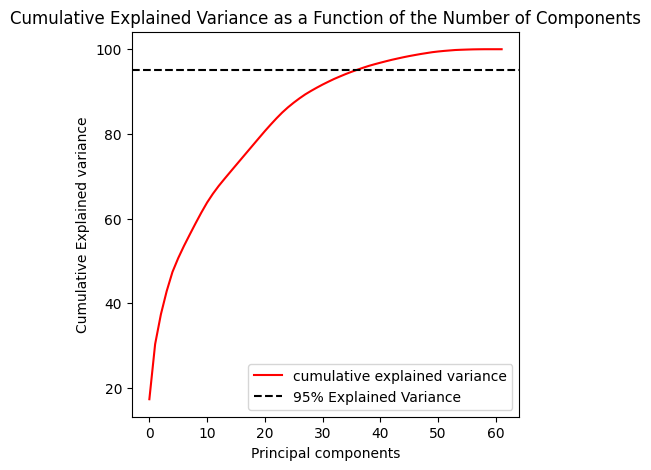

In [61]:
scaler.fit(vocalsound_gemaps_dataset)
vocalsound_gemaps_scaler = scaler.transform(vocalsound_gemaps_dataset)

plot_relation_between_VAR_and_DIM(vocalsound_gemaps_scaler)

vocalsound_gemaps_pca = pca_transform(vocalsound_gemaps_scaler)

In [62]:
cv_for_vs(models_VS, names_VS, vocalsound_gemaps_pca, vocalsound_targets_gemaps)

SVM_Poly:
-----------------------------------------------------------------
|  Class                     | Recall         | Precision      |
-----------------------------------------------------------------
| cough/кашель               |  0.577 ± 0.020 | 0.587 ± 0.016 |
| laugh/смех                 |  0.657 ± 0.016 | 0.800 ± 0.010 |
| sigh/вздох                 |  0.764 ± 0.009 | 0.787 ± 0.007 |
| sneeze/чихание             |  0.559 ± 0.015 | 0.674 ± 0.011 |
| sniff/вдыхание носом       |  0.712 ± 0.007 | 0.810 ± 0.006 |
| throatcl./прочищение горла |  0.687 ± 0.007 | 0.455 ± 0.013 |
-----------------------------------------------------------------
Average Scores               |  0.565 ± 0.011 | 0.588 ± 0.009 |
-----------------------------------------------------------------
Accuracy Score: 0.658 ± 0.004                                  |
-----------------------------------------------------------------

SVM_RBF:
-----------------------------------------------------------------
|  Cla

### Vocal Sound - eGEMAPS Features

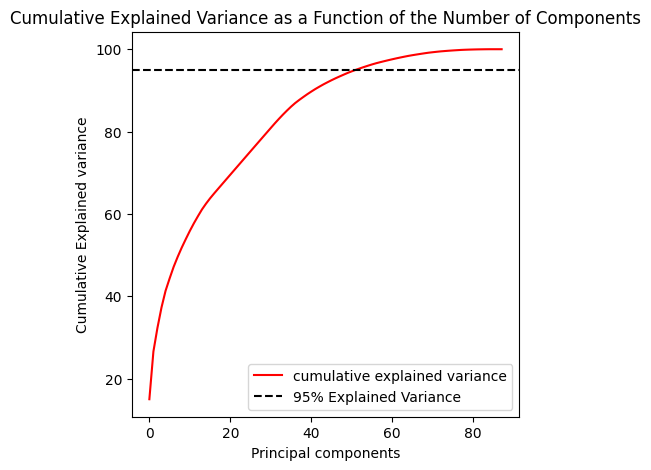

In [63]:
scaler.fit(vocalsound_egemaps_dataset)
vocalsound_egemaps_scaler = scaler.transform(vocalsound_egemaps_dataset)

plot_relation_between_VAR_and_DIM(vocalsound_egemaps_scaler)

vocalsound_egemaps_pca = pca_transform(vocalsound_egemaps_scaler)

In [64]:
cv_for_vs(models_VS, names_VS, vocalsound_egemaps_pca, vocalsound_targets_egemaps)

SVM_Poly:
-----------------------------------------------------------------
|  Class                     | Recall         | Precision      |
-----------------------------------------------------------------
| cough/кашель               |  0.708 ± 0.008 | 0.548 ± 0.008 |
| laugh/смех                 |  0.695 ± 0.014 | 0.800 ± 0.008 |
| sigh/вздох                 |  0.790 ± 0.006 | 0.821 ± 0.006 |
| sneeze/чихание             |  0.633 ± 0.012 | 0.704 ± 0.008 |
| sniff/вдыхание носом       |  0.759 ± 0.011 | 0.833 ± 0.005 |
| throatcl./прочищение горла |  0.670 ± 0.014 | 0.633 ± 0.017 |
-----------------------------------------------------------------
Average Scores               |  0.608 ± 0.009 | 0.620 ± 0.007 |
-----------------------------------------------------------------
Accuracy Score: 0.709 ± 0.004                                  |
-----------------------------------------------------------------

SVM_RBF:
-----------------------------------------------------------------
|  Cla

### Vocal Sound - Interspeech 2009 Features

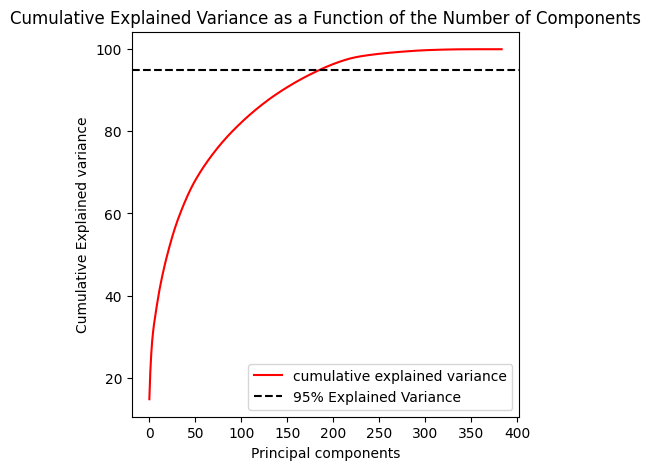

In [65]:
scaler.fit(vocalsound_is09_dataset)
vocalsound_IS09_scaler = scaler.transform(vocalsound_is09_dataset)

plot_relation_between_VAR_and_DIM(vocalsound_IS09_scaler)

vocalsound_IS09_pca = pca_transform(vocalsound_IS09_scaler)

In [66]:
cv_for_vs(models_VS, names_VS, vocalsound_IS09_pca, vocalsound_targets_is09)

SVM_Poly:
-----------------------------------------------------------------
|  Class                     | Recall         | Precision      |
-----------------------------------------------------------------
| cough/кашель               |  0.742 ± 0.018 | 0.460 ± 0.017 |
| laugh/смех                 |  0.597 ± 0.029 | 0.777 ± 0.009 |
| sigh/вздох                 |  0.660 ± 0.017 | 0.848 ± 0.007 |
| sneeze/чихание             |  0.616 ± 0.011 | 0.823 ± 0.009 |
| sniff/вдыхание носом       |  0.721 ± 0.009 | 0.859 ± 0.004 |
| throatcl./прочищение горла |  0.693 ± 0.021 | 0.566 ± 0.025 |
-----------------------------------------------------------------
Average Scores               |  0.575 ± 0.015 | 0.619 ± 0.010 |
-----------------------------------------------------------------
Accuracy Score: 0.671 ± 0.007                                  |
-----------------------------------------------------------------

SVM_RBF:
-----------------------------------------------------------------
|  Cla

### Vocal Sound - Interspeech 2010 Features

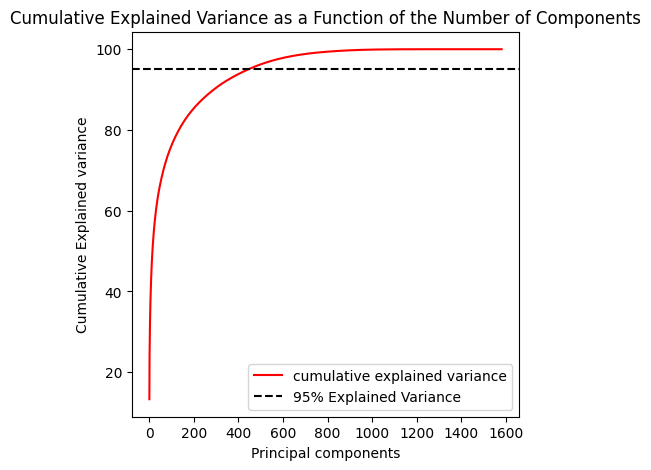

In [67]:
scaler.fit(vocalsound_is10_dataset)
vocalsound_IS10_scaler = scaler.transform(vocalsound_is10_dataset)

plot_relation_between_VAR_and_DIM(vocalsound_IS10_scaler)

vocalsound_IS10_pca = pca_transform(vocalsound_IS10_scaler)

In [68]:
cv_for_vs(models_VS, names_VS, vocalsound_IS10_pca, vocalsound_targets_is10)

SVM_Poly:
-----------------------------------------------------------------
|  Class                     | Recall         | Precision      |
-----------------------------------------------------------------
| cough/кашель               |  0.716 ± 0.038 | 0.688 ± 0.028 |
| laugh/смех                 |  0.675 ± 0.006 | 0.888 ± 0.012 |
| sigh/вздох                 |  0.738 ± 0.007 | 0.881 ± 0.005 |
| sneeze/чихание             |  0.767 ± 0.013 | 0.707 ± 0.013 |
| sniff/вдыхание носом       |  0.768 ± 0.008 | 0.879 ± 0.008 |
| throatcl./прочищение горла |  0.771 ± 0.011 | 0.557 ± 0.026 |
-----------------------------------------------------------------
Average Scores               |  0.633 ± 0.012 | 0.657 ± 0.013 |
-----------------------------------------------------------------
Accuracy Score: 0.739 ± 0.005                                  |
-----------------------------------------------------------------

SVM_RBF:
-----------------------------------------------------------------
|  Cla

### Vocal Sound - Interspeech 2013 Features

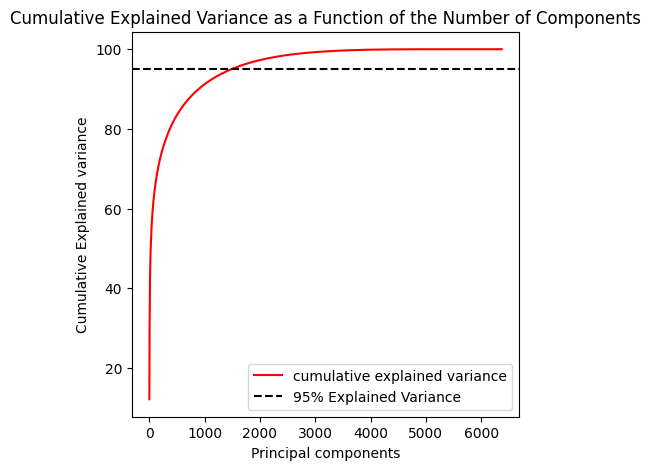

In [69]:
scaler.fit(vocalsound_is13_dataset)
vocalsound_IS13_scaler = scaler.transform(vocalsound_is13_dataset)

plot_relation_between_VAR_and_DIM(vocalsound_IS13_scaler)

vocalsound_IS13_pca = pca_transform(vocalsound_IS13_scaler)

In [70]:
cv_for_vs(models_VS, names_VS, vocalsound_IS13_pca, vocalsound_targets_is13)

SVM_Poly:
-----------------------------------------------------------------
|  Class                     | Recall         | Precision      |
-----------------------------------------------------------------
| cough/кашель               |  0.490 ± 0.028 | 0.754 ± 0.009 |
| laugh/смех                 |  0.598 ± 0.013 | 0.885 ± 0.011 |
| sigh/вздох                 |  0.708 ± 0.012 | 0.893 ± 0.008 |
| sneeze/чихание             |  0.682 ± 0.040 | 0.781 ± 0.025 |
| sniff/вдыхание носом       |  0.747 ± 0.015 | 0.912 ± 0.005 |
| throatcl./прочищение горла |  0.852 ± 0.008 | 0.392 ± 0.012 |
-----------------------------------------------------------------
Average Scores               |  0.582 ± 0.017 | 0.660 ± 0.010 |
-----------------------------------------------------------------
Accuracy Score: 0.679 ± 0.006                                  |
-----------------------------------------------------------------

SVM_RBF:
-----------------------------------------------------------------
|  Cla